In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [11]:
n_train = 5000
n_test = 500

def get_mask(n_total, n_sample):
  mask = np.zeros(n_total)
  mask[:n_sample] = 1
  np.random.shuffle(mask)

  return mask

train_mask = get_mask(len(X_train), n_train)
test_mask = get_mask(len(X_test), n_test)

X_train_sampled, y_train_sampled = X_train[train_mask == 1], y_train[train_mask == 1]
X_test_sampled, y_test_sampled = X_test[test_mask == 1], y_test[test_mask == 1]

X_train_sampled.shape, y_train_sampled.shape, X_test_sampled.shape, y_test_sampled.shape

((5000, 32, 32, 3), (5000, 1), (500, 32, 32, 3), (500, 1))

## Model

In [0]:
class KNN:
  def __init__(self, *, k, dist=None):
    self.k = k
    self.dist = dist or "l1"

    assert self.dist in ["l1", "l2"]

    print(f"Using distance: {self.dist}")

  def fit(self, X_train, y_train):
    self.X_train = X_train
    self.y_train = y_train

  def predict(self, X_batch):
    X_batch_expanded = np.expand_dims(X_batch, 1)
    
    delta = np.abs(self.X_train - X_batch_expanded)
    if self.dist == "l1":
      distance = np.sum(delta, axis=(2, 3, 4))
    elif self.dist == "l2":
      distance = np.sqrt(np.sum(delta ** 2, axis=(2, 3, 4)))
    else:
      raise NotImplementedError(f"Unsupported distance function! dist: {dist}")
    
    closest_k_indices = np.argsort(distance, axis=1)[:, :self.k]
    closest_k_labels = np.take_along_axis(
        self.y_train.reshape(1, -1), 
        closest_k_indices, 
        axis=1
    )

    def get_most_frequent(arr):
      bincount = np.bincount(arr)
      return np.argmax(bincount)

    pred = np.apply_along_axis(
        get_most_frequent, 1, closest_k_labels
    ).reshape(-1)
    ret = pred.reshape(-1)

    return ret

  def evaluate(self, X_test, y_test, batch_size=100, quiet=False):
    n_sample = X_test.shape[0]
    n_correct = 0

    batch_idx = 0
    n_evaluated = 0
    while batch_idx < n_sample:
      X_batch, y_batch = X_test[batch_idx:batch_idx + batch_size], y_test.reshape(-1)[batch_idx:batch_idx + batch_size]

      pred_batch = self.predict(X_batch)

      n_evaluated += len(X_batch)
      n_correct += sum(pred == label for pred, label in zip(pred_batch, y_batch))

      if not quiet:
        print(f"Evaluated {n_evaluated} samples, {n_correct} labels are correct. Accuracy: {n_correct / n_evaluated}")

      batch_idx += batch_size
    
    accuracy = n_correct / n_evaluated
    return accuracy

In [110]:
l1_mod = KNN(k=1)
l1_mod.fit(X_train_sampled, y_train_sampled)

Using distance: l1


In [111]:
l1_mod.predict(X_test_sampled[:3])

array([1, 0, 9])

In [112]:
l1_mod.evaluate(X_test_sampled, y_test_sampled, batch_size=100)

Evaluated 100 samples, 23 labels are correct. Accuracy: 0.23
Evaluated 200 samples, 50 labels are correct. Accuracy: 0.25
Evaluated 300 samples, 78 labels are correct. Accuracy: 0.26
Evaluated 400 samples, 99 labels are correct. Accuracy: 0.2475
Evaluated 500 samples, 114 labels are correct. Accuracy: 0.228


0.228

### Evaluation

In [0]:
list_k = list(range(1, 11))

In [118]:
l1_eval = []

for k in list_k:
  mod = KNN(k=k, dist="l1")
  mod.fit(X_train_sampled, y_train_sampled)

  accuracy = mod.evaluate(X_test_sampled, y_test_sampled, batch_size=100, quiet=True)
  l1_eval.append(accuracy)

Using distance: l1
Using distance: l1
Using distance: l1
Using distance: l1
Using distance: l1
Using distance: l1
Using distance: l1
Using distance: l1
Using distance: l1
Using distance: l1


In [119]:
l2_eval = []

for k in list_k:
  mod = KNN(k=k, dist="l2")
  mod.fit(X_train_sampled, y_train_sampled)

  accuracy = mod.evaluate(X_test_sampled, y_test_sampled, batch_size=100, quiet=True)
  l2_eval.append(accuracy)

Using distance: l2
Using distance: l2
Using distance: l2
Using distance: l2
Using distance: l2
Using distance: l2
Using distance: l2
Using distance: l2
Using distance: l2
Using distance: l2


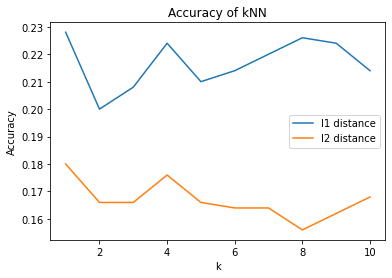

In [122]:
fig, ax = plt.subplots()

ax.plot(list_k, l1_eval, label="l1 distance")
ax.plot(list_k, l2_eval, label="l2 distance")
ax.set(
    title="Accuracy of kNN",
    xlabel="k",
    ylabel="Accuracy"
)

plt.legend()
plt.show()

## Helpers

In [0]:
def render_image(x):
  """Given a (32, 32, 3) array, render the image.
  
  :x: np.array of dimension (32, 32, 3)

  """
  fig, ax = plt.subplots(figsize=(3,3))
  ax.set_axis_off()
  ax.imshow(x)

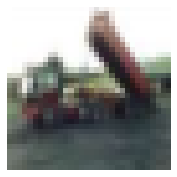

In [8]:
render_image(X_train[2])